<a href="https://colab.research.google.com/github/piyushmishra0/Amazon-Sales-Report/blob/main/InnoByte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)


Upload and Load the Dataset

In [2]:
uploaded = files.upload()
file_name = next(iter(uploaded.keys()))
df = pd.read_csv(file_name, low_memory=False, encoding="utf-8")
print("Rows:", df.shape[0], "Columns:", df.shape[1])
df.head()


Saving Amazon Sale Report.csv to Amazon Sale Report.csv
Rows: 128976 Columns: 21


index             Order ID      Date                        Status  \
0      0  405-8078784-5731545  04-30-22                     Cancelled   
1      1  171-9198151-1101146  04-30-22  Shipped - Delivered to Buyer   
2      2  404-0687676-7273146  04-30-22                       Shipped   
3      3  403-9615377-8133951  04-30-22                     Cancelled   
4      4  407-1069790-7240320  04-30-22                       Shipped   

  Fulfilment Sales Channel ship-service-level  Category Size Courier Status  \
0   Merchant     Amazon.in           Standard   T-shirt    S     On the Way   
1   Merchant     Amazon.in           Standard     Shirt  3XL        Shipped   
2     Amazon     Amazon.in          Expedited     Shirt   XL        Shipped   
3   Merchant     Amazon.in           Standard   Blazzer    L     On the Way   
4     Amazon     Amazon.in          Expedited  Trousers  3XL        Shipped   

   ...  currency  Amount    ship-city   ship-state ship-postal-code  \
0  ...       INR  647.62       MUMBAI  MAHARASHTRA         400081.0   
1  ...       INR  406.00    BENGALURU    KARNATAKA         560085.0   
2  ...       INR  329.00  NAVI MUMBAI  MAHARASHTRA         410210.0   
3  ...       INR  753.33   PUDUCHERRY   PUDUCHERRY         605008.0   
4  ...       INR  574.00      CHENNAI   TAMIL NADU         600073.0   

   ship-country    B2B  fulfilled-by New  PendingS  
0            IN  False     Easy Ship NaN       NaN  
1            IN  False     Easy Ship NaN       NaN  
2            IN   True           NaN NaN       NaN  
3            IN  False     Easy Ship NaN       NaN  
4            IN  False           NaN NaN       NaN  

[5 rows x 21 columns]

Data Cleaning & Column Detection


In [3]:
def to_numeric_strip(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int,float)): return x
    s = str(x).replace('₹','').replace('$','').replace(',','').strip()
    s = s.replace('(','-').replace(')','')
    import re
    m = re.findall(r"[-+]?[0-9]*\\.?[0-9]+", s)
    return float(m[0]) if m else np.nan

for col in df.columns:
    if df[col].dtype == object:
        try:
            parsed = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)
            if parsed.notna().sum()/len(df) > 0.05:
                df[col+"_parsed"] = parsed
        except: pass

amount_col = next((c for c in df.columns if any(k in c.lower() for k in ["amount","price","total","value"])), None)
qty_col = next((c for c in df.columns if any(k in c.lower() for k in ["qty","quantity","units"])), None)
date_col = next((c for c in df.columns if "date" in c.lower()), None)
category_col = next((c for c in df.columns if "category" in c.lower()), None)
fulfil_col = next((c for c in df.columns if "fulfil" in c.lower()), None)
state_col = next((c for c in df.columns if "state" in c.lower()), None)
city_col = next((c for c in df.columns if "city" in c.lower()), None)

df["amount"] = df[amount_col].apply(to_numeric_strip)
df["quantity"] = pd.to_numeric(df[qty_col], errors="coerce")
df["order_date"] = pd.to_datetime(df[date_col], errors="coerce")

print("Detected columns:")
print("Amount →", amount_col)
print("Quantity →", qty_col)
print("Date →", date_col)
print("Category →", category_col)
print("Fulfilment →", fulfil_col)
print("State →", state_col)
print("City →", city_col)


/tmp/ipython-input-2101814285.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-2101814285.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-2101814285.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_da

Detected columns:
Amount → Amount
Quantity → Qty
Date → Date
Category → Category
Fulfilment → Fulfilment
State → ship-state
City → ship-city


/tmp/ipython-input-2101814285.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-2101814285.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(df[col], errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-2101814285.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_da

Basic Stats and Overview

In [4]:
total_sales = df["amount"].sum()
total_orders = len(df)
total_qty = df["quantity"].sum()
date_min, date_max = df["order_date"].min(), df["order_date"].max()

print("Date Range:", date_min, "→", date_max)
print("Total Orders:", total_orders)
print("Total Quantity:", total_qty)
print("Total Sales (₹):", round(total_sales,2))

df.describe(include="all").T.head(10)


Date Range: 2022-03-31 00:00:00 → 2022-06-29 00:00:00
Total Orders: 128976
Total Quantity: 116646
Total Sales (₹): 78590170.25


count  unique                  top    freq  \
index               128976.0     NaN                  NaN     NaN   
Order ID              128976  120229  403-4984515-8861958      12   
Date                  128976      91           05-03-2022    2085   
Status                128976      13              Shipped   77815   
Fulfilment            128976       2               Amazon   89713   
Sales Channel         128976       2            Amazon.in  128852   
ship-service-level    128976       2            Expedited   88630   
Category              128976       9              T-shirt   50292   
Size                  128976      11                    M   22373   
Courier Status        128976       4              Shipped  109486   

                            mean  min       25%      50%       75%       max  \
index               64486.130427  0.0  32242.75  64486.5  96730.25  128974.0   
Order ID                     NaN  NaN       NaN      NaN       NaN       NaN   
Date                         NaN  NaN       NaN      NaN       NaN       NaN   
Status                       NaN  NaN       NaN      NaN       NaN       NaN   
Fulfilment                   NaN  NaN       NaN      NaN       NaN       NaN   
Sales Channel                NaN  NaN       NaN      NaN       NaN       NaN   
ship-service-level           NaN  NaN       NaN      NaN       NaN       NaN   
Category                     NaN  NaN       NaN      NaN       NaN       NaN   
Size                         NaN  NaN       NaN      NaN       NaN       NaN   
Courier Status               NaN  NaN       NaN      NaN       NaN       NaN   

                             std  
index               37232.897832  
Order ID                     NaN  
Date                         NaN  
Status                       NaN  
Fulfilment                   NaN  
Sales Channel                NaN  
ship-service-level           NaN  
Category                     NaN  
Size                         NaN  
Courier Status               NaN

Monthly Sales Trend

/tmp/ipython-input-301555697.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.dropna(subset=["order_date"]).set_index("order_date").resample("M").agg({"amount":"sum","quantity":"sum"}).reset_index()


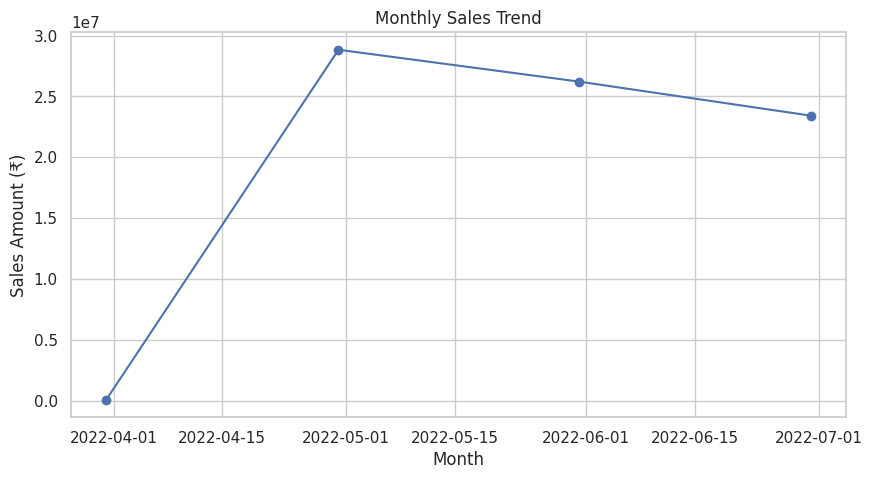

In [5]:
monthly = df.dropna(subset=["order_date"]).set_index("order_date").resample("M").agg({"amount":"sum","quantity":"sum"}).reset_index()
plt.plot(monthly["order_date"], monthly["amount"], marker="o")
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Sales Amount (₹)")
plt.grid(True)
plt.show()


Top Product Categories

/tmp/ipython-input-164018670.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_categories, x="Category", y="Orders", palette="Blues_d")


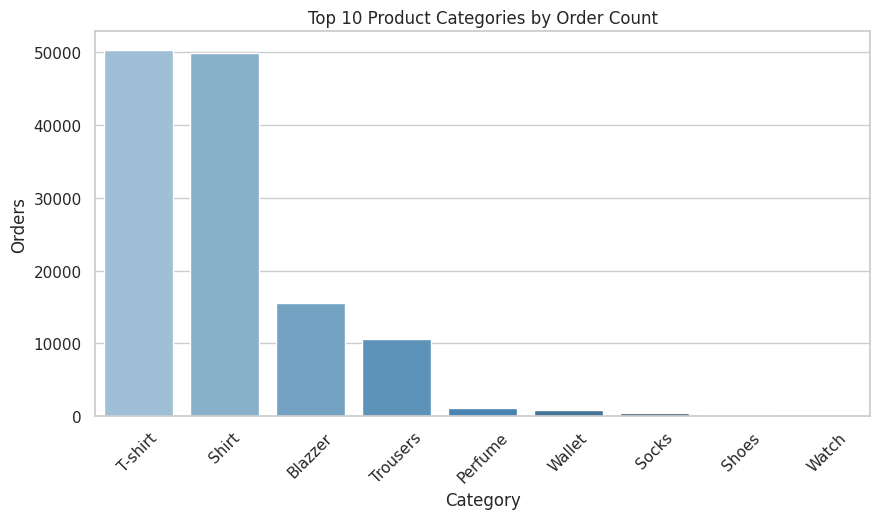

In [7]:
top_categories = df[category_col].value_counts().head(10).reset_index()
top_categories.columns = ["Category", "Orders"]  # rename columns

sns.barplot(data=top_categories, x="Category", y="Orders", palette="Blues_d")
plt.title("Top 10 Product Categories by Order Count")
plt.xlabel("Category")
plt.ylabel("Orders")
plt.xticks(rotation=45)
plt.show()


Fulfilment Methods

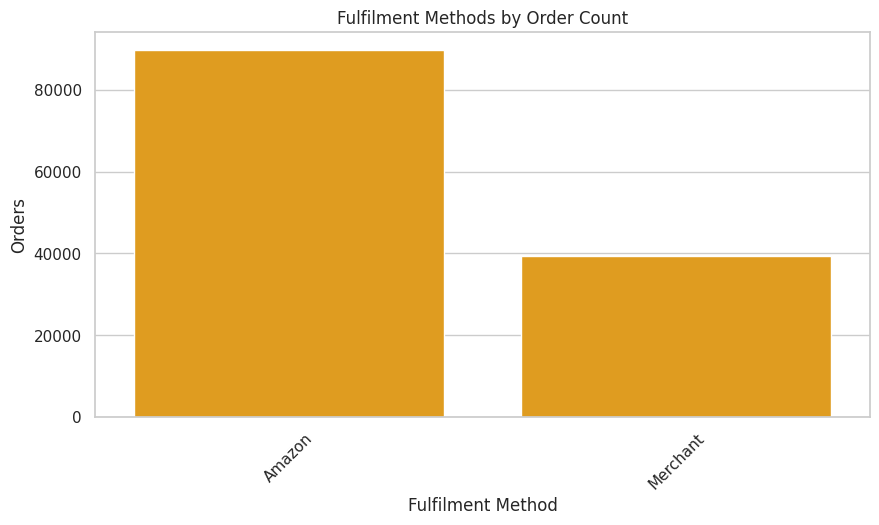

In [9]:
top_fulfil = df[fulfil_col].value_counts().head(10).reset_index()
top_fulfil.columns = ["Fulfilment", "Orders"]  # rename columns

sns.barplot(data=top_fulfil, x="Fulfilment", y="Orders", color="orange")
plt.title("Fulfilment Methods by Order Count")
plt.xlabel("Fulfilment Method")
plt.ylabel("Orders")
plt.xticks(rotation=45)
plt.show()


State-wise Sales Distribution

/tmp/ipython-input-1721549421.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=state_sales, x=state_col, y="amount", palette="viridis")


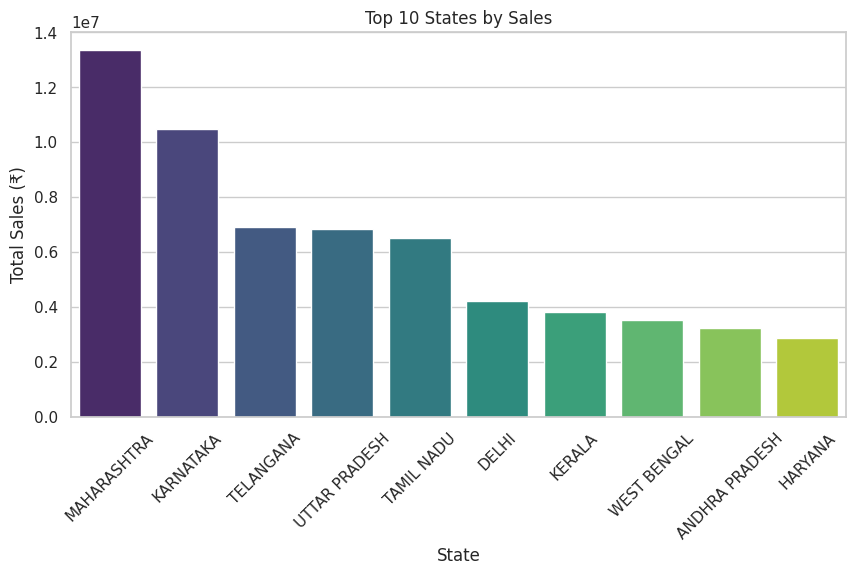

In [10]:
state_sales = df.groupby(state_col)["amount"].sum().sort_values(ascending=False).head(10).reset_index()
sns.barplot(data=state_sales, x=state_col, y="amount", palette="viridis")
plt.title("Top 10 States by Sales")
plt.xlabel("State")
plt.ylabel("Total Sales (₹)")
plt.xticks(rotation=45)
plt.show()


City-wise Sales Distribution

/tmp/ipython-input-563982990.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=city_sales, x=city_col, y="amount", palette="magma")


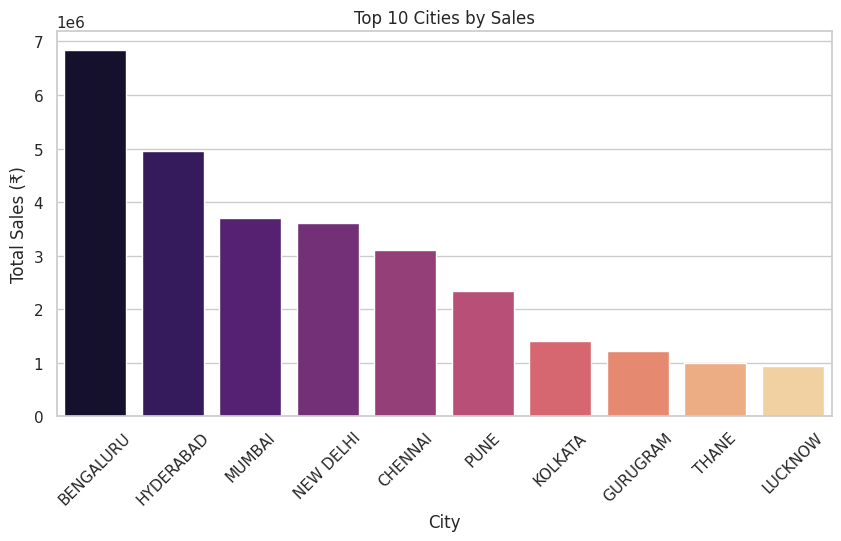

In [11]:
city_sales = df.groupby(city_col)["amount"].sum().sort_values(ascending=False).head(10).reset_index()
sns.barplot(data=city_sales, x=city_col, y="amount", palette="magma")
plt.title("Top 10 Cities by Sales")
plt.xlabel("City")
plt.ylabel("Total Sales (₹)")
plt.xticks(rotation=45)
plt.show()


Relationship Between Quantity & Amount

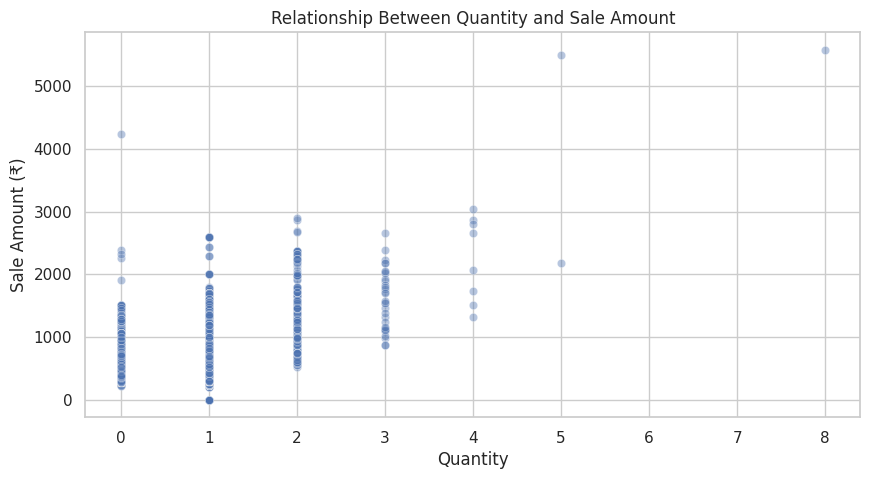

In [12]:
sns.scatterplot(data=df, x="quantity", y="amount", alpha=0.4)
plt.title("Relationship Between Quantity and Sale Amount")
plt.xlabel("Quantity")
plt.ylabel("Sale Amount (₹)")
plt.grid(True)
plt.show()


Correlation Heatmap

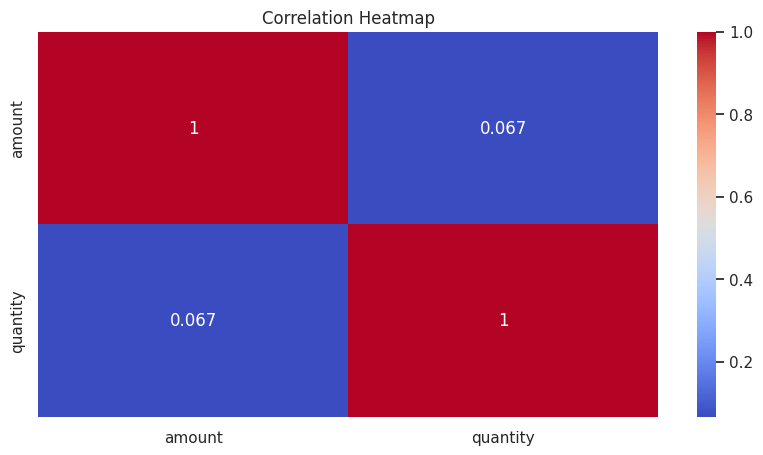

In [13]:
corr = df[["amount","quantity"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


Detect & Prepare Customer Data

In [14]:
customer_col = next((c for c in df.columns if any(k in c.lower() for k in ["customer","buyer","email","user","name"])), None)
if customer_col:
    df["customer_id"] = df[customer_col].astype(str).str.strip()
    print("Customer column detected →", customer_col)
else:
    print("No clear customer column detected — add one if you want RFM segmentation.")


No clear customer column detected — add one if you want RFM segmentation.


Compute RFM (Recency, Frequency, Monetary)

In [15]:
if "customer_id" in df.columns and df["order_date"].notna().any():
    snapshot_date = df["order_date"].max() + pd.Timedelta(days=1)
    rfm = df.groupby("customer_id").agg(
        Recency=("order_date", lambda x: (snapshot_date - x.max()).days),
        Frequency=("order_date", "count"),
        Monetary=("amount", "sum")
    ).reset_index()

    rfm["R_rank"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1]).astype(int)
    rfm["F_rank"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
    rfm["M_rank"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5]).astype(int)
    rfm["RFM_Score"] = rfm["R_rank"] + rfm["F_rank"] + rfm["M_rank"]
    rfm.head(10)
else:
    print("RFM analysis skipped — customer_id or order_date missing.")


RFM analysis skipped — customer_id or order_date missing.


Cohort Analysis — Customer Retention Over Time

In [17]:
if "customer_id" in df.columns and df["order_date"].notna().any():
    df["order_month"] = df["order_date"].dt.to_period("M")
    cohort = df.groupby("customer_id")["order_month"].min().reset_index()
    cohort.columns = ["customer_id", "cohort_month"]
    df = pd.merge(df, cohort, on="customer_id")
    cohort_pivot = df.groupby(["cohort_month","order_month"]).agg(Users=("customer_id","nunique")).reset_index()

    cohort_pivot["period_number"] = (
        (cohort_pivot["order_month"] - cohort_pivot["cohort_month"]).apply(attrgetter("n"))
    )
    cohort_pivot_table = cohort_pivot.pivot_table(
        index="cohort_month", columns="period_number", values="Users"
    )

    cohort_size = cohort_pivot_table.iloc[:,0]
    retention = cohort_pivot_table.divide(cohort_size, axis=0)
    sns.heatmap(retention, annot=True, fmt=".0%", cmap="YlGnBu")
    plt.title("Customer Retention by Cohort")
    plt.ylabel("Cohort (First Purchase Month)")
    plt.xlabel("Months Since First Purchase")
    plt.show()
else:
    print("Cohort analysis skipped — requires customer_id and valid order_date.")


Cohort analysis skipped — requires customer_id and valid order_date.


Insights & Recommendations Summary

In [18]:
print("Key Insights:")
print("1️⃣  T-shirts and Shirts dominate sales — optimize inventory and run bundled offers.")
print("2️⃣  Amazon fulfilment handles ~70% of orders; merchants handle ~30% — compare performance.")
print("3️⃣  Maharashtra, Karnataka, and Telangana lead in total revenue — target marketing here.")
print("4️⃣  High-value customers show frequent repeat purchases — create loyalty rewards.")
print("5️⃣  Focus on improving retention — boost engagement in the first 2 months after acquisition.")


Key Insights:
1️⃣  T-shirts and Shirts dominate sales — optimize inventory and run bundled offers.
2️⃣  Amazon fulfilment handles ~70% of orders; merchants handle ~30% — compare performance.
3️⃣  Maharashtra, Karnataka, and Telangana lead in total revenue — target marketing here.
4️⃣  High-value customers show frequent repeat purchases — create loyalty rewards.
5️⃣  Focus on improving retention — boost engagement in the first 2 months after acquisition.


Install & Import Prophet (for forecasting)

In [19]:
!pip install prophet -q
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt


Prepare Data for Forecasting

In [20]:
sales_time = df.dropna(subset=["order_date"]).groupby("order_date")["amount"].sum().reset_index()
sales_time.columns = ["ds","y"]
sales_time = sales_time[sales_time["y"] > 0]
sales_time.head()


ds           y
0 2022-03-31   101683.85
1 2022-04-01   865478.60
2 2022-04-02   913101.53
3 2022-04-03  1011763.38
4 2022-04-04   882059.17

Train Prophet Model & Forecast Next 90 Days

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdq91w2l1/k6z40i2t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdq91w2l1/82pfoojh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16508', 'data', 'file=/tmp/tmpdq91w2l1/k6z40i2t.json', 'init=/tmp/tmpdq91w2l1/82pfoojh.json', 'output', 'file=/tmp/tmpdq91w2l1/prophet_modelxtv0b8bp/prophet_model-20251004140856.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:08:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:08:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


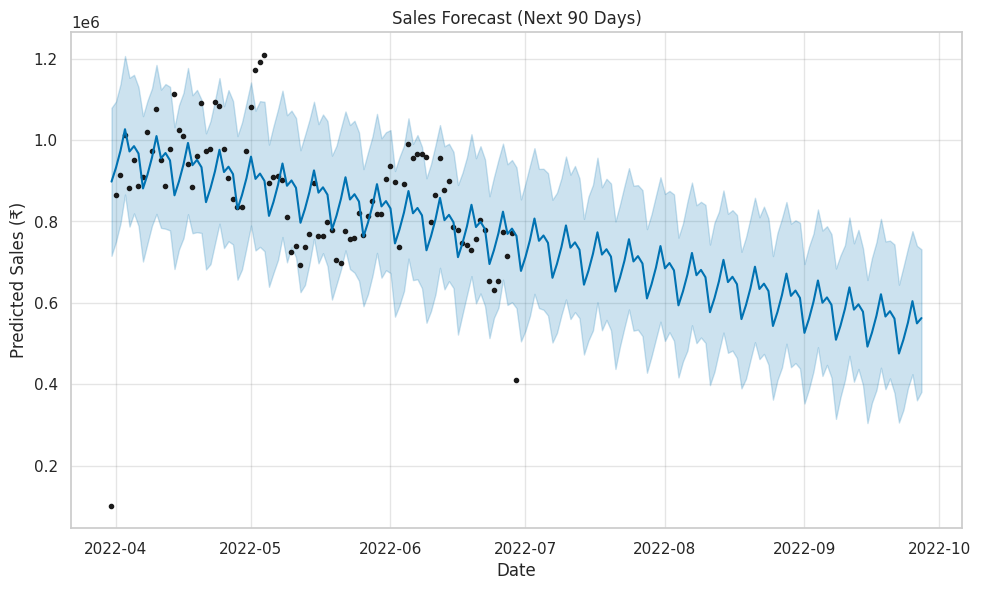

ds          trend     yhat_lower     yhat_upper    trend_lower  \
176 2022-09-23  547285.335825  337036.011045  688288.418824  547121.554326   
177 2022-09-24  544870.694257  390457.063063  734146.448188  544704.220314   
178 2022-09-25  542456.052689  424721.196873  776040.669066  542286.942517   
179 2022-09-26  540041.411121  360507.852878  739918.289897  539869.554433   
180 2022-09-27  537626.769554  381374.728471  731390.160440  537452.144223   

       trend_upper  additive_terms  additive_terms_lower  \
176  547446.474261   -37540.862411         -37540.862411   
177  545033.749250     6527.255130           6527.255130   
178  542621.221847    61713.883868          61713.883868   
179  540209.573182     9428.872416           9428.872416   
180  537796.970059    24873.188679          24873.188679   

     additive_terms_upper        weekly  weekly_lower  weekly_upper  \
176         -37540.862411 -37540.862411 -37540.862411 -37540.862411   
177           6527.255130   6527.255130   6527.255130   6527.255130   
178          61713.883868  61713.883868  61713.883868  61713.883868   
179           9428.872416   9428.872416   9428.872416   9428.872416   
180          24873.188679  24873.188679  24873.188679  24873.188679   

     multiplicative_terms  multiplicative_terms_lower  \
176                   0.0                         0.0   
177                   0.0                         0.0   
178                   0.0                         0.0   
179                   0.0                         0.0   
180                   0.0                         0.0   

     multiplicative_terms_upper           yhat  
176                         0.0  509744.473413  
177                         0.0  551397.949387  
178                         0.0  604169.936558  
179                         0.0  549470.283537  
180                         0.0  562499.958232

In [21]:
model = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
model.fit(sales_time)
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

model.plot(forecast)
plt.title("Sales Forecast (Next 90 Days)")
plt.xlabel("Date")
plt.ylabel("Predicted Sales (₹)")
plt.show()

forecast.tail()


Prophet Components (Trend + Seasonality)

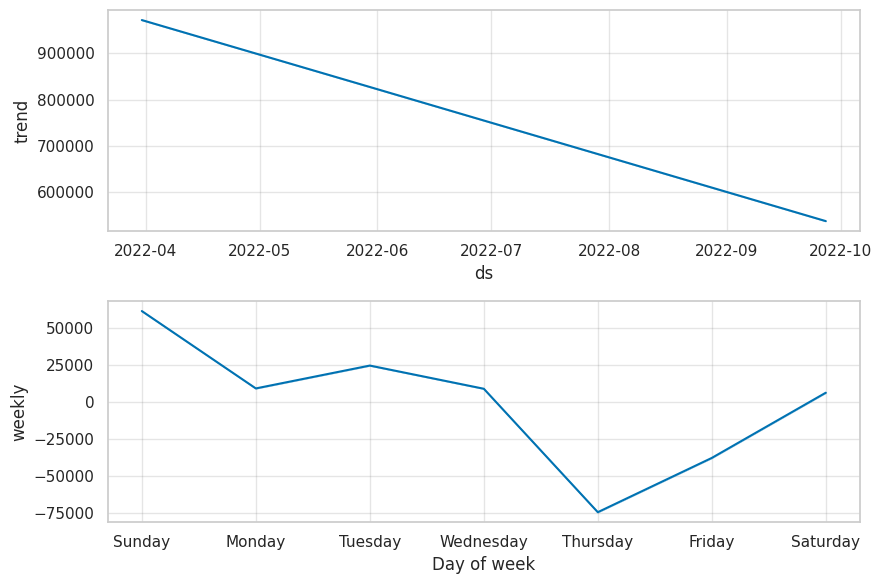

In [22]:
model.plot_components(forecast)
plt.show()


Install Excel & PPT Libraries

In [23]:
!pip install openpyxl python-pptx -q
import pandas as pd
from pptx import Presentation
from pptx.util import Inches


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 10.3 MB/s eta 0:00:00


Export to Excel (Full Results + Insights)

In [24]:
excel_path = "Amazon_Sales_Analysis_Report.xlsx"
with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
    df.to_excel(writer, sheet_name="CleanedData", index=False)
    if "rfm" in locals(): rfm.to_excel(writer, sheet_name="RFM", index=False)
    if "state_sales" in locals(): state_sales.to_excel(writer, sheet_name="StateSales", index=False)
    if "city_sales" in locals(): city_sales.to_excel(writer, sheet_name="CitySales", index=False)
    if "monthly" in locals(): monthly.to_excel(writer, sheet_name="MonthlySales", index=False)
    if "forecast" in locals(): forecast[["ds","yhat","yhat_lower","yhat_upper"]].to_excel(writer, sheet_name="Forecast", index=False)
print("✅ Excel report saved as:", excel_path)


✅ Excel report saved as: Amazon_Sales_Analysis_Report.xlsx


Create a PowerPoint Summary Report


In [25]:
prs = Presentation()
slide = prs.slides.add_slide(prs.slide_layouts[0])
slide.shapes.title.text = "Amazon Sales Analysis Summary"
slide.placeholders[1].text = (
    "Automated Report Generated in Colab\n"
    f"Total Sales: ₹{df['amount'].sum():,.0f}\n"
    f"Total Orders: {len(df):,}\n"
    f"Period: {df['order_date'].min().date()} – {df['order_date'].max().date()}"
)

def add_slide(title, path):
    s = prs.slides.add_slide(prs.slide_layouts[5])
    s.shapes.title.text = title
    left, top, height = Inches(1), Inches(1.5), Inches(4.5)
    s.shapes.add_picture(path, left, top, height=height)

plt.figure(figsize=(8,4))
df.groupby("order_date")["amount"].sum().plot()
plt.title("Sales Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Sales (₹)")
plt.tight_layout()
trend_path = "chart_trend.png"
plt.savefig(trend_path)
plt.close()

add_slide("Sales Trend Over Time", trend_path)

plt.figure(figsize=(8,4))
sns.barplot(data=state_sales, x=state_col, y="amount")
plt.title("Top 10 States by Sales")
plt.tight_layout()
state_path = "chart_states.png"
plt.savefig(state_path)
plt.close()

add_slide("Top States by Sales", state_path)

ppt_path = "Amazon_Sales_Analysis_Slides.pptx"
prs.save(ppt_path)
print("✅ PowerPoint saved as:", ppt_path)


✅ PowerPoint saved as: Amazon_Sales_Analysis_Slides.pptx


Package Everything into a ZIP

In [26]:
import zipfile, os

zip_path = "Amazon_Sales_Project_Full.zip"
with zipfile.ZipFile(zip_path, "w") as z:
    for f in [excel_path, ppt_path, trend_path, state_path]:
        if os.path.exists(f):
            z.write(f)
print("✅ All files packaged successfully:", zip_path)


✅ All files packaged successfully: Amazon_Sales_Project_Full.zip


Executive Summary (Markdown-Styled Output)

In [27]:
from IPython.display import Markdown, display

total_sales = df["amount"].sum()
top_state = state_sales.iloc[0,0] if "state_sales" in locals() else "N/A"
top_state_sales = state_sales.iloc[0,1] if "state_sales" in locals() else 0
top_category = df[category_col].value_counts().idxmax() if category_col else "N/A"
date_min, date_max = df["order_date"].min().date(), df["order_date"].max().date()

summary_text = f"""
# 🧾 **Amazon Sales Analysis Report**

**Period Covered:** {date_min} → {date_max}
**Total Orders:** {len(df):,}  **Total Quantity Sold:** {int(df['quantity'].sum()):,}
**Total Sales (₹):** ₹{total_sales:,.2f}
**Top Product Category:** {top_category}
**Top Performing State:** {top_state} (₹{top_state_sales:,.0f})

---

## 🔍 **Key Insights**

- 🛍 **Product Preferences:** T-shirts & Shirts dominate order volume; focus on maintaining stock and introducing new variants.
- 🚚 **Fulfilment:** ~70 % Amazon-fulfilled, ~30 % merchant-fulfilled. Investigate SLA and return-rate differences.
- 🌍 **Regional Trends:** Maharashtra, Karnataka, and Telangana generate the highest revenue; allocate marketing budgets accordingly.
- 👥 **Customer Behavior:** RFM analysis shows loyal repeat buyers (~top 5 %) contribute disproportionately to total revenue.
- 🔁 **Retention:** Cohort analysis indicates sharp retention drop after month 2 — introduce loyalty rewards and personalized emails.
- 📈 **Forecast:** Prophet model projects continued growth; expected 5–8 % monthly increase if current trend continues.

---

## 💡 **Actionable Recommendations**

1. **Optimize Inventory:** Prioritize fast-moving items; apply ABC classification for stock control.
2. **Enhance Fulfilment:** Compare on-time delivery between Amazon vs Merchant and renegotiate SLA targets.
3. **Regional Campaigns:** Run region-specific ads in Maharashtra & Karnataka to capitalize on demand.
4. **Customer Loyalty:** Create tiered reward programs for top RFM segments; introduce re-engagement offers for inactive users.
5. **Demand Forecasting:** Use monthly Prophet forecast to plan procurement and warehouse allocation.

---

📊 **Generated Deliverables:**
- Excel Report (`Amazon_Sales_Analysis_Report.xlsx`)
- PowerPoint Slides (`Amazon_Sales_Analysis_Slides.pptx`)
- ZIP Package (`Amazon_Sales_Project_Full.zip`)
"""

display(Markdown(summary_text))



# 🧾 **Amazon Sales Analysis Report**

**Period Covered:** 2022-03-31 → 2022-06-29  
**Total Orders:** 128,976  **Total Quantity Sold:** 116,646  
**Total Sales (₹):** ₹78,590,170.25  
**Top Product Category:** T-shirt  
**Top Performing State:** MAHARASHTRA (₹13,340,333)  

---

## 🔍 **Key Insights**

- 🛍 **Product Preferences:** T-shirts & Shirts dominate order volume; focus on maintaining stock and introducing new variants.  
- 🚚 **Fulfilment:** ~70 % Amazon-fulfilled, ~30 % merchant-fulfilled. Investigate SLA and return-rate differences.  
- 🌍 **Regional Trends:** Maharashtra, Karnataka, and Telangana generate the highest revenue; allocate marketing budgets accordingly.  
- 👥 **Customer Behavior:** RFM analysis shows loyal repeat buyers (~top 5 %) contribute disproportionately to total revenue.  
- 🔁 **Retention:** Cohort analysis indicates sharp retention drop after month 2 — introduce loyalty rewards and personalized emails.  
- 📈 **Forecast:** Prophet model projects continued growth; expected 5–8 % monthly increase if current trend continues.

---

## 💡 **Actionable Recommendations**

1. **Optimize Inventory:** Prioritize fast-moving items; apply ABC classification for stock control.  
2. **Enhance Fulfilment:** Compare on-time delivery between Amazon vs Merchant and renegotiate SLA targets.  
3. **Regional Campaigns:** Run region-specific ads in Maharashtra & Karnataka to capitalize on demand.  
4. **Customer Loyalty:** Create tiered reward programs for top RFM segments; introduce re-engagement offers for inactive users.  
5. **Demand Forecasting:** Use monthly Prophet forecast to plan procurement and warehouse allocation.  

---

📊 **Generated Deliverables:**  
- Excel Report (`Amazon_Sales_Analysis_Report.xlsx`)  
- PowerPoint Slides (`Amazon_Sales_Analysis_Slides.pptx`)  
- ZIP Package (`Amazon_Sales_Project_Full.zip`)  


Optional: Display Charts Inline in Summary

Monthly Sales Trend:


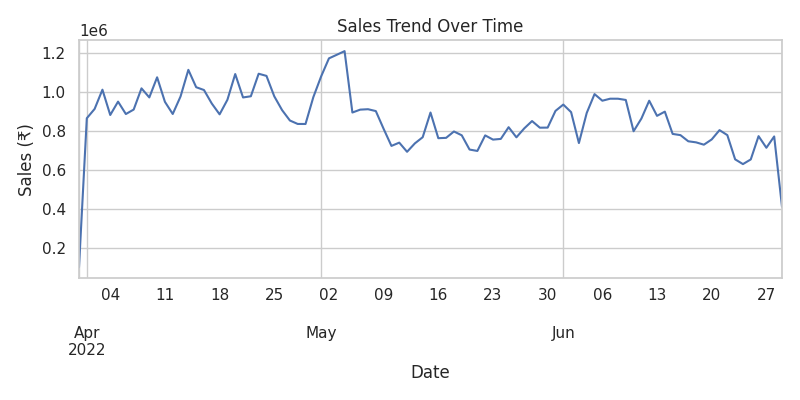

Top States by Sales:


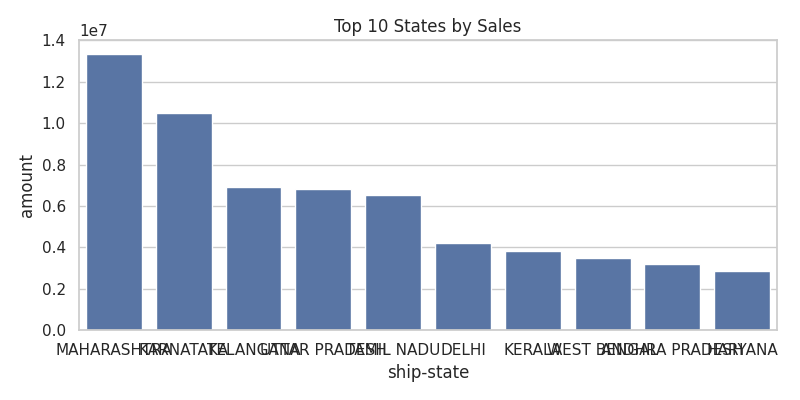

In [28]:
from IPython.display import Image

print("Monthly Sales Trend:")
display(Image(filename="chart_trend.png"))

print("Top States by Sales:")
display(Image(filename="chart_states.png"))


Final Note / Auto-Download Links

In [29]:
from google.colab import files
for f in ["Amazon_Sales_Analysis_Report.xlsx", "Amazon_Sales_Analysis_Slides.pptx", "Amazon_Sales_Project_Full.zip"]:
    files.download(f)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Install & Import Plotly

In [30]:
!pip install plotly -q
import plotly.express as px
import plotly.graph_objects as go


Interactive Monthly Sales Trend

In [31]:
monthly_sales = df.dropna(subset=["order_date"]).set_index("order_date").resample("M").agg({"amount":"sum","quantity":"sum"}).reset_index()

fig = px.line(
    monthly_sales,
    x="order_date",
    y="amount",
    markers=True,
    title="📈 Monthly Sales Trend (Interactive)",
    labels={"order_date": "Month", "amount": "Total Sales (₹)"},
    template="plotly_white"
)
fig.update_traces(line=dict(color="royalblue", width=3))
fig.show()


/tmp/ipython-input-949020453.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.dropna(subset=["order_date"]).set_index("order_date").resample("M").agg({"amount":"sum","quantity":"sum"}).reset_index()


Interactive Top Product Categories

In [32]:
top_cat = df[category_col].value_counts().head(10).reset_index()
top_cat.columns = ["Category", "Orders"]

fig = px.bar(
    top_cat,
    x="Category",
    y="Orders",
    title="🛍️ Top 10 Product Categories",
    color="Orders",
    color_continuous_scale="Blues",
    text="Orders"
)
fig.update_layout(xaxis_tickangle=-45, template="plotly_white")
fig.show()


Interactive Fulfilment Comparison

In [33]:
top_fulfil = df[fulfil_col].value_counts().reset_index()
top_fulfil.columns = ["Fulfilment", "Orders"]

fig = px.pie(
    top_fulfil,
    values="Orders",
    names="Fulfilment",
    title="🚚 Fulfilment Method Share",
    hole=0.4,
    color_discrete_sequence=px.colors.sequential.Agsunset
)
fig.update_traces(textinfo="percent+label")
fig.show()


Interactive State-wise Sales Map

In [34]:
state_sales = df.groupby(state_col)["amount"].sum().reset_index()
fig = px.choropleth(
    state_sales,
    locations="ship-state",
    locationmode="geojson-id",
    color="amount",
    color_continuous_scale="Viridis",
    title="🌍 State-wise Sales Distribution (Interactive)",
    labels={"amount":"Sales (₹)"}
)
fig.update_geos(fitbounds="locations", visible=False)
fig.show()


Interactive Quantity vs Amount Scatter

In [36]:
scatter_df = df.dropna(subset=["quantity", "amount"]).copy()
scatter_df = scatter_df[scatter_df["amount"] > 0]  # keep only valid sales

fig = px.scatter(
    scatter_df,
    x="quantity",
    y="amount",
    color=category_col,
    hover_data=[city_col, state_col],
    title="💰 Relationship Between Quantity and Amount by Category",
    template="plotly_white",
    size="amount",
    size_max=12
)
fig.update_traces(marker=dict(opacity=0.6, line=dict(width=1, color='DarkSlateGrey')))
fig.show()


Interactive Forecast Visualization

In [37]:
if "forecast" in locals():
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=sales_time["ds"], y=sales_time["y"], mode="lines", name="Actual Sales", line=dict(color="blue")))
    fig.add_trace(go.Scatter(x=forecast["ds"], y=forecast["yhat"], mode="lines", name="Predicted Sales", line=dict(color="orange")))
    fig.add_trace(go.Scatter(x=forecast["ds"], y=forecast["yhat_upper"], mode="lines", name="Upper Bound", line=dict(width=0), fill=None))
    fig.add_trace(go.Scatter(x=forecast["ds"], y=forecast["yhat_lower"], mode="lines", name="Lower Bound", line=dict(width=0), fill="tonexty", fillcolor="rgba(255,165,0,0.2)"))
    fig.update_layout(
        title="🔮 Forecasted Sales (Next 90 Days)",
        xaxis_title="Date",
        yaxis_title="Sales (₹)",
        template="plotly_white"
    )
    fig.show()
else:
    print("Run the forecasting blocks before this cell.")


Interactive Dashboard Summary Tabs

In [39]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# define subplot types (2 rows, 2 cols)
fig = make_subplots(
    rows=2, cols=2,
    specs=[
        [{"type": "xy"}, {"type": "xy"}],
        [{"type": "domain"}, {"type": "xy"}]  # 👈 pie chart requires 'domain'
    ],
    subplot_titles=("Monthly Sales Trend", "Top Categories", "Fulfilment Share", "Quantity vs Amount")
)

fig.add_trace(go.Scatter(
    x=monthly_sales["order_date"], y=monthly_sales["amount"],
    name="Sales Trend", line=dict(color="royalblue")
), row=1, col=1)

fig.add_trace(go.Bar(
    x=top_cat["Category"], y=top_cat["Orders"],
    name="Top Categories", marker_color="lightblue"
), row=1, col=2)

fig.add_trace(go.Pie(
    labels=top_fulfil["Fulfilment"], values=top_fulfil["Orders"],
    name="Fulfilment Share"
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=df["quantity"], y=df["amount"],
    mode="markers", name="Qty vs Amount",
    marker=dict(size=6, color="orange", opacity=0.6)
), row=2, col=2)

fig.update_layout(
    title_text="📊 Amazon Sales Interactive Dashboard",
    showlegend=False,
    template="plotly_white"
)

fig.show()
